In [1]:
import pandas as pd
import numpy as np
from time import time
import tensorflow as tf
import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K

%matplotlib inline
print(tf.keras.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


2.1.6-tf
['/job:localhost/replica:0/task:0/device:GPU:0']


In [11]:
# Input constants
HEIGHT = 32
WIDTH = 32
CHANNELS = 3
NUM_CLASSES = 10

base_model = keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                  include_top=False, 
                                                  input_shape=(HEIGHT, WIDTH, CHANNELS))

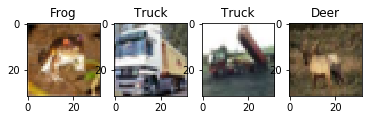

In [12]:
def append_ext(fn):
    return fn+".png"

traindf=pd.read_csv("./trainLabels.csv",dtype=str)
testdf=pd.read_csv("./sampleSubmission.csv",dtype=str)
traindf["id"]=traindf["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)
#datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

#visualizing some examples
IMG_PATH_1 = "train/1.PNG"
IMG_PATH_2 = "train/2.PNG"
IMG_PATH_3 = "train/3.PNG"
IMG_PATH_4 = "train/4.PNG"

fig = plt.figure()
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Frog') 
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_2), cmap='gray', vmin=0, vmax=1)
a.set_title('Truck') 
a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_3), cmap='gray', vmin=0, vmax=1)
a.set_title('Truck');
a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_4), cmap='gray', vmin=0, vmax=1)
a.set_title('Deer');

In [13]:
BATCH_SIZE = 50
VALIDATION_SPLIT = 0.25
NUM_IMAGES = 50000
NUM_TEST_IMAGES = 20000
NUM_TRAIN_IMAGES = NUM_IMAGES*(1-VALIDATION_SPLIT)
NUM_VAL_IMAGES = NUM_IMAGES*VALIDATION_SPLIT

train_datagen =  keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
                                                              validation_split=VALIDATION_SPLIT)

train_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory="./train/",
                                                    x_col="id",
                                                    y_col="label",
                                                    subset="training",
                                                    batch_size=BATCH_SIZE,
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT,WIDTH))

valid_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                                directory="./train/",
                                                x_col="id",
                                                y_col="label",
                                                subset="validation",
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(HEIGHT,WIDTH))

test_datagen =  keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf,
                                                    directory="./test/",
                                                    x_col="id",
                                                    y_col=None,
                                                    batch_size=BATCH_SIZE,
                                                    seed=42,
                                                    shuffle=False,
                                                    class_mode=None,
                                                    target_size=(HEIGHT,WIDTH))

Found 37500 images belonging to 10 classes.
Found 12500 images belonging to 10 classes.
Found 20000 images.


In [14]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x) 
    finetune_model = keras.models.Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

# Top Layer constants
FC_LAYERS = [30, 30]
DROPOUT = 0.05

finetune_model = build_finetune_model(base_model, 
                                      dropout=DROPOUT, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=NUM_CLASSES)

In [16]:
# Training constants
NUM_EPOCHS = 5
LEARNING_RATE = 0.003
DECAY = 1e-6

#Callbacks
FILEPATH_SAVE='checkpoints/ResNet50_{}_model_weights.h5'.format(time())
FILEPATH_TENSORBOARD_LOG = 'logdir/{}'.format(int(time()))

checkpoint = keras.callbacks.ModelCheckpoint(FILEPATH_SAVE,
                                             monitor=["acc"],
                                             verbose=1,
                                             mode='max')
                                               
early_stopping = keras.callbacks.EarlyStopping(monitor='acc',
                                               min_delta=0.002,
                                               patience=4,
                                               verbose=0,
                                               mode='auto',
                                               restore_best_weights=True)
                                               
tensorboard = keras.callbacks.TensorBoard(log_dir = FILEPATH_TENSORBOARD_LOG, write_images=True)

callbacks_list = [tensorboard]

finetune_model.compile(keras.optimizers.rmsprop(lr=LEARNING_RATE, decay=DECAY),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = finetune_model.fit_generator(train_generator, 
                                       epochs=NUM_EPOCHS,
                                       workers=8, 
                                       steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE, 
                                       validation_data = valid_generator,
                                       validation_steps = NUM_VAL_IMAGES // BATCH_SIZE,
                                       shuffle=True,
                                       callbacks=callbacks_list,
                                       verbose=2
                                      )

#starting Tensorboard:
#tensorboard --logdir='C:\Users\Laurenz\Desktop\Vision_Control_Laurenz\vision_control\Development\Laurenz\dataframe_tutorial\logdir\' --host localhost --port 8088
#Navigated the browser to http://localhost:8088

Epoch 1/5
 - 104s - loss: 1.7270 - acc: 0.3903 - val_loss: 2.3352 - val_acc: 0.3522
Epoch 2/5
 - 103s - loss: 1.5285 - acc: 0.4754 - val_loss: 2.4053 - val_acc: 0.4270
Epoch 3/5
 - 104s - loss: 1.4681 - acc: 0.4997 - val_loss: 2.3705 - val_acc: 0.3875
Epoch 4/5
 - 103s - loss: 1.4273 - acc: 0.5104 - val_loss: 2.4411 - val_acc: 0.4070
Epoch 5/5
 - 110s - loss: 1.4035 - acc: 0.5198 - val_loss: 2.6035 - val_acc: 0.4118


In [ ]:
finetune_model.evaluate_generator(generator=valid_generator,
steps=NUM_VAL_IMAGES // BATCH_SIZE)

In [ ]:
test_generator.reset()
pred=finetune_model.predict_generator(test_generator,
                                        steps=NUM_TEST_IMAGES // BATCH_SIZE,
                                        verbose=1)

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_transfer_learning.csv",index=False)

In [ ]:
finetune_model.save('cifar10_trained_with_transfer_learning.h5')